In [16]:
import cv2
import json
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, confusion_matrix

In [17]:
tools = ['accendino', 'cacciavite', 'chiave', 'forbici', 'martello', 'metro', 'nastro', 'pappagallo', 'penna', 'spillatrice']
tp_tot, tn_tot, fp_tot, fn_tot = [], [], [], []


for tool in tqdm(tools):

    with open(f"C:/Users\mcm23\OneDrive\Desktop\GitHub\Object_Detection\images\{tool}\{tool}_gt.json", 'r') as f:
        ground_truth_file = json.load(f)

    for pos, el in enumerate(ground_truth_file):
        # Ground truth.
        x_pos = ground_truth_file[el]['regions'][0]['shape_attributes']['all_points_x']
        y_pos = ground_truth_file[el]['regions'][0]['shape_attributes']['all_points_y']
        vertices = np.array([[x_pos[i], y_pos[i]] for i in range(len(x_pos))])

        image = cv2.imread(f"C:/Users\mcm23\OneDrive\Desktop\GitHub\Object_Detection\images\{tool}\{tool}_{pos+1}.png")

        # Preprocessing delle immagini.
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        threshold = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

        # Applicare ground truth all'immagine.
        truth_mask = np.zeros_like(threshold)
        cv2.fillPoly(truth_mask, [vertices], 255)
        truth_mask = truth_mask.astype(bool).flatten()

        # Segmentazione.
        kernel = np.ones((5,5), np.uint8)
        opening = cv2.morphologyEx(threshold, cv2.MORPH_OPEN, kernel, iterations=2)
        opening = opening.astype(bool)
        opening = np.array([not elem for elem in opening.flatten()])

        # Confronto tra segmentazione e ground truth.
        ground_truth = truth_mask.flatten()
        predictions = [not elem for elem in opening.flatten()]
        tn, fp, fn, tp = confusion_matrix(ground_truth, predictions, labels=[True, False]).ravel()
        tp_tot.append(tp)
        tn_tot.append(tn)
        fp_tot.append(fp)
        fn_tot.append(fn)

100%|██████████| 10/10 [00:28<00:00,  2.82s/it]


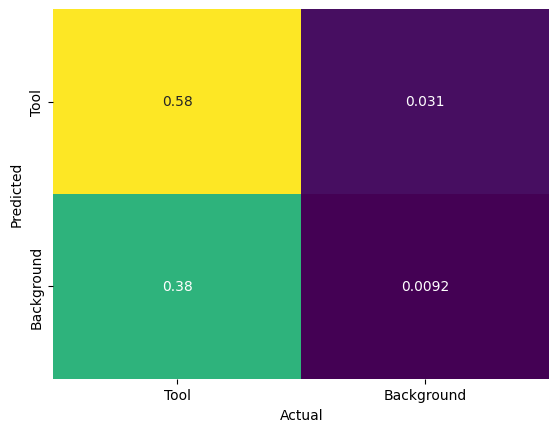

In [18]:
sum_tp = sum(tp_tot)
sum_tn = sum(tn_tot)
sum_fp = sum(fp_tot)
sum_fn = sum(fn_tot)

tot = sum_tp + sum_tn + sum_fp + sum_fn


cf_matrix = np.array([[sum_tp/tot, sum_fp/tot],
                       [sum_fn/tot, sum_tn/tot]])

labels = ['Tool', 'Background']
sns.heatmap(cf_matrix, annot=True, cmap='viridis',  xticklabels=labels, yticklabels=labels, cbar=False)
plt.xlabel('Actual')
plt.ylabel('Predicted');